# Stereo Vision

In [ ]:
# !wget https://chrisjmccormick.files.wordpress.com/2014/01/left.png
# !wget https://chrisjmccormick.files.wordpress.com/2014/01/right.png
# !wget https://andyzeng.github.io/img/proj/cv/blockmatching/left2.png
# !wget https://andyzeng.github.io/img/proj/cv/blockmatching/right2.png
# !wget https://andyzeng.github.io/img/proj/cv/blockmatching/left3.png
# !wget https://andyzeng.github.io/img/proj/cv/blockmatching/right3.png
!wget https://cs.uwaterloo.ca/~yboykov/Images/Stereo/Pairs/scene_l.pgm
!wget https://cs.uwaterloo.ca/~yboykov/Images/Stereo/Pairs/scene_r.pgm

--2021-05-30 16:12:39--  https://andyzeng.github.io/img/proj/cv/blockmatching/left2.png
Resolving andyzeng.github.io (andyzeng.github.io)... 185.199.110.153, 185.199.111.153, 185.199.109.153, ...
Connecting to andyzeng.github.io (andyzeng.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 342036 (334K) [image/png]
Saving to: ‘left2.png’

left2.png           100%[===================>] 334.02K  --.-KB/s    in 0.03s   

2021-05-30 16:12:40 (11.5 MB/s) - ‘left2.png’ saved [342036/342036]

--2021-05-30 16:12:40--  https://andyzeng.github.io/img/proj/cv/blockmatching/right2.png
Resolving andyzeng.github.io (andyzeng.github.io)... 185.199.110.153, 185.199.111.153, 185.199.109.153, ...
Connecting to andyzeng.github.io (andyzeng.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 343316 (335K) [image/png]
Saving to: ‘right2.png’

right2.png          100%[===================>] 335.27K  --.-KB/s    

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

left_image= cv2.imread('/content/scene_l.png', 0)
right_image= cv2.imread('/content/scene_r.png', 0)
d=20

(288, 384)


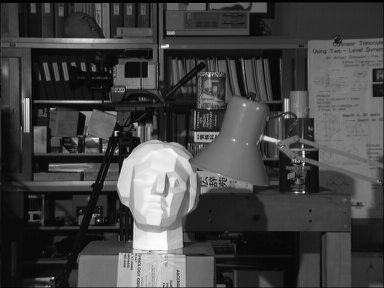

In [ ]:
print(left_image.shape)
cv2_imshow(left_image)

(288, 384)


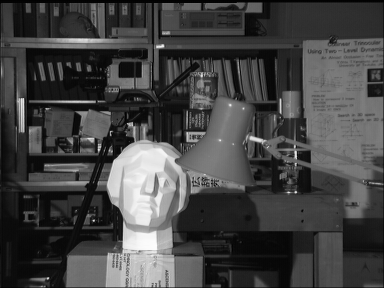

In [ ]:
print(right_image.shape)
cv2_imshow(right_image)

## 1 Block Matching

### SAD: Sum of Absolute Differences

http://www.cse.psu.edu/~rtc12/CSE486/lecture09.pdf

In [ ]:
def sad(left_image, right_image, w, d):
    length,width = left_image.shape
    result = np.zeros((length,width)) #,d
    w = int(np.floor(w/2))
    # Loop in left image
    for x in range(w, length - w):
        for y in range(w, width - w):
            prevsad = 65000
            # loop to get best value of disparity with least sad
            for i in range(d):
              sad = 0
              # Loop in right image
              for v in range(-w, w + 1):
                  for u in range(-w, w + 1):
                      sad += np.absolute(int(left_image[x+v, y+u]) - int(right_image[x+v, y+u-i]))
              # sad = np.sum(np.absolute(left_image[x-w:x+w+1,y-w:y+w+1] - right_image[x-w:x+w+1,y-w-i:y+w+1-i])) # slower
              if (sad < prevsad):
                prevsad = sad
                result[x,y] = i * (255/d) #int(np.floor(255/d))
    print(result.shape)    
    return result

comparing results with 

https://andyzeng.github.io/blockmatching

(288, 384)


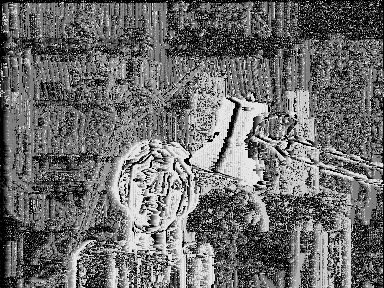

(288, 384)


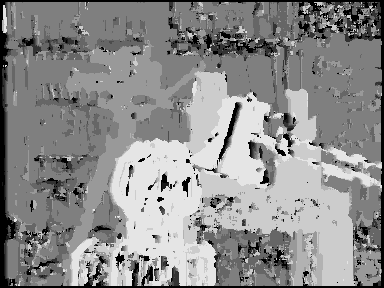

(288, 384)


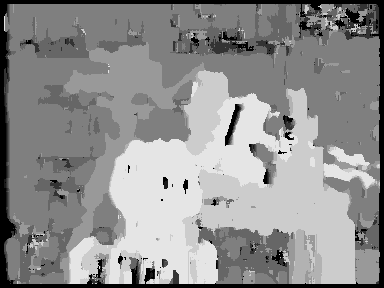

In [ ]:
for w in [1,5,9]:
  cv2_imshow(sad(left_image, right_image, w, 10))

### SSD: Sum of Squared Differences

In [ ]:
def ssd(left_image, right_image, w, d):
    length,width = left_image.shape
    result = np.zeros((length,width),np.uint8) #,d
    w = int(w/2)
    # Loop in left image
    for x in range(w, length - w):
        for y in range(w, width - w):
            # loop to get best value of disparity with least ssd
            prevssd = 65000
            for i in range(0, d):
              ssd = 0
              # Loop in right window 
              for v in range(-w, w+1 ):
                  for u in range(-w, w+1 ):
                      ssd += (int(left_image[x+v, y+u]) - int(right_image[x+v, y+u-i]))**2
              if (ssd < prevssd):
                prevssd = ssd
                result[x,y] = i * (255/d)
    print(result.shape)    
    return result

(288, 384)


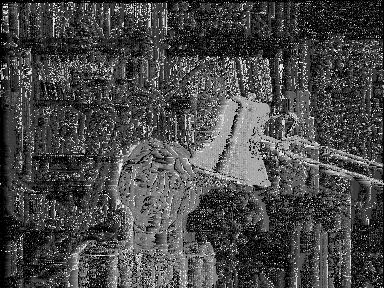

(288, 384)


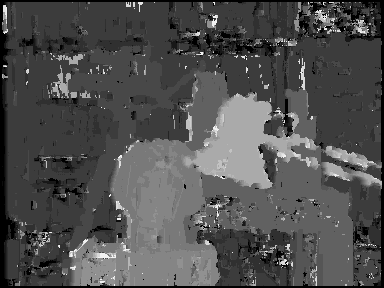

(288, 384)


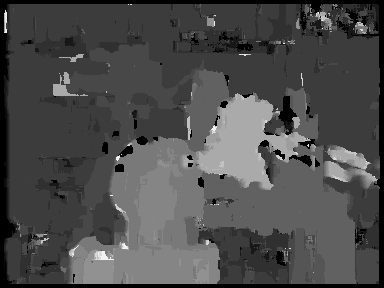

In [ ]:
for w in [1,5,9]:
  cv2_imshow(ssd(left_image, right_image, w, d))

## 2 Dynamic programming

In [ ]:
def DP_Stereo(left_image, right_image):
  M,N = left_image.shape
  segma = 2 # noise
  C0 = 1 # cost of skipping pixel
  disparity = 0
  D = np.zeros((N, N)) # The intermediate values, where  total cost of matching two scanlines is D(N, N ).
  direction = np.zeros((N, N)) # to use while working backwards 
  result = np.zeros((M,N),np.uint8)
  for currentrow in range(M):
    # D[0,0] =  abs(int(left_image[currentrow, 0]) - int(right_image[currentrow, 0]))**2/segma**2
    for i in range(1,N):
      D[i,0] = i*C0
    for i in range(1,N):
      D[0,i] = i*C0
    for i in range(1,N):
      Ili = left_image[currentrow, i]
      for j in range(1,N):
        Irj = right_image[currentrow, j]
        dij = abs(Ili - Irj)**2/segma**2
        D[i,j] = min(D[i-1,j-1]+dij,D[i-1,j]+C0,D[i,j-1]+C0)
        if (D[i,j] ==  D[i-1,j]+C0):
           direction[i,j] = 2 # or 2 
        elif (D[i,j] ==  D[i,j-1]+C0):
              direction[i,j] = 3
        elif (D[i,j] ==  D[i-1,j-1]+dij):
            direction[i,j] = 1
    # backword
    # disparity = 0
    l = N-1
    r = N-1
    scanlineM = np.zeros((N, N))
    while l!=0 and r!=0 :
      scanlineM[l,r] = 255
      if (direction[l,r] == 1):
        result[currentrow,l] = int(abs(l-r))
        l-=1
        r-=1
      elif (direction[l,r] == 2):
        #  Selecting (i - 1, j) corresponds to skipping a pixel in Il
        disparity+=1
        l-=1
      elif (direction[l,r] == 3):
        #  Selecting (i, j - 1) corresponds to skipping a pixel in Ir
        disparity-=1
        r-=1
    # return scanlineM, disparity # print line
  # print(result.max())
  return result*int(255/result.max()), disparity

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in ubyte_scalars


121


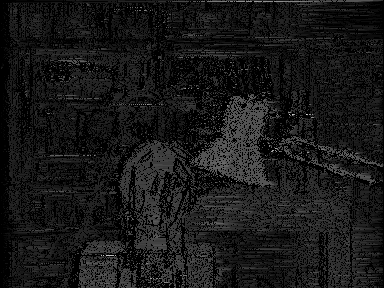

In [ ]:
img, d = DP_Stereo(left_image, right_image)
print(d)
cv2_imshow(img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in ubyte_scalars


0


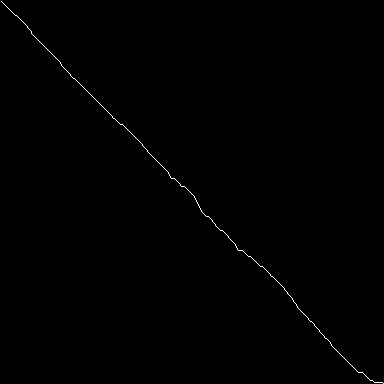

In [ ]:
img, d = DP_Stereo(left_image, right_image)
print(d)
cv2_imshow(img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in ubyte_scalars


-3929


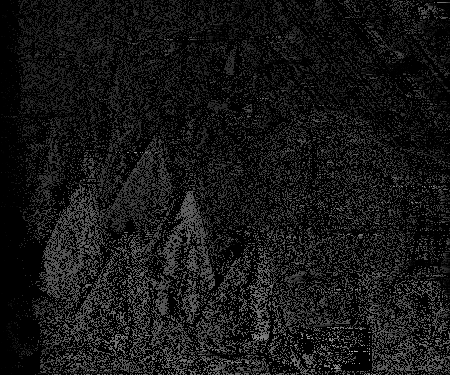

In [ ]:
img, d = DP_Stereo(left_image, right_image)
print(d)
cv2_imshow(img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in ubyte_scalars


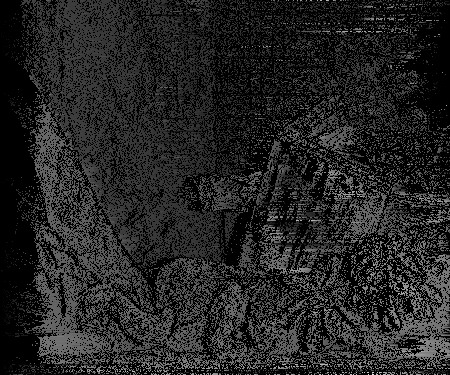

In [ ]:
img, d = DP_Stereo(left_image, right_image)
# print(d)
cv2_imshow(img)